In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from prefect.blocks.system import Secret
from catnip.fla_redshift import FLA_Redshift
from typing import Dict
from concurrent.futures import ThreadPoolExecutor

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import DistanceMetric
import gower

import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import rand_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

In [3]:
q = """
select 
    *, split_part(split_part(how_important_are_these_entertainment_related_factors_when_you_attend_a_game, ',',6),':',2) as theme_night,
    split_part(split_part(how_important_are_these_entertainment_related_factors_when_you_attend_a_game, ',',9), ':', 2) as fans_who_care,
    split_part(split_part(how_important_are_these_team_related_factors_when_you_attend_a_game, ',',1), ':', 2) as exciting_game,
    split_part(split_part(how_important_are_these_experience_related_factors_when_you_attend_a_game, ',',9), ':', 2) as luxury_seating,
    split_part(split_part(how_important_are_these_experience_related_factors_when_you_attend_a_game, ',',12), ':', 2) as giveaways,
    case
        when what_kind_of_tickets_do_you_purchase like '%Season Tickets%' then 'Season Tickets'
        when what_kind_of_tickets_do_you_purchase like '%Nightly Suites%' then 'Nightly Suites'
        when what_kind_of_tickets_do_you_purchase like '%Flex/Mini Plans%' then 'Flex/Mini Plans'
        when what_kind_of_tickets_do_you_purchase like '%Groups%' then 'Groups'
        else 'Single Game'
    end as ticket_type                 
from 
    custom.formstack_v_fan_segmentation
"""
df = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [4]:
X = df[['age', 'gender', 'household_income', 'how_closely_do_you_follow_the_florida_panthers',
        'how_far_in_advance_do_you_normally_purchase_tickets', 'when_do_you_enjoy_going_to_hockey_games',
        'theme_night', 'fans_who_care','exciting_game', 'luxury_seating', 'giveaways', 'ticket_type']]
# X = df[['age', 'gender', 'household_income', 'how_closely_do_you_follow_the_florida_panthers','ticket_type']]

In [5]:
dict1 = {}
for column in X:
    temp = dict(enumerate(X[str(column)].unique()))
    dict1[str(column)] = temp

In [6]:
for key1, value1 in dict1.items():
    for key, value in value1.items():
        X.loc[X[str(key1)] == value, str(key1)] = key

C:\Users\riffere\AppData\Local\Temp\ipykernel_5144\1174034588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X[str(key1)] == value, str(key1)] = key


In [7]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)

In [8]:
tsne = TSNE()
principalComponents = tsne.fit_transform(X)

In [9]:
principalDf = pd.DataFrame(data = principalComponents,
             columns = ['PC1', 'PC2'])
kmeans = KMeans(n_clusters=5, random_state=1993, n_init=100).fit(principalDf)
target = pd.DataFrame(data = kmeans.labels_, columns = ['Target'])
finaldf = pd.concat([principalDf, target], axis =1,)

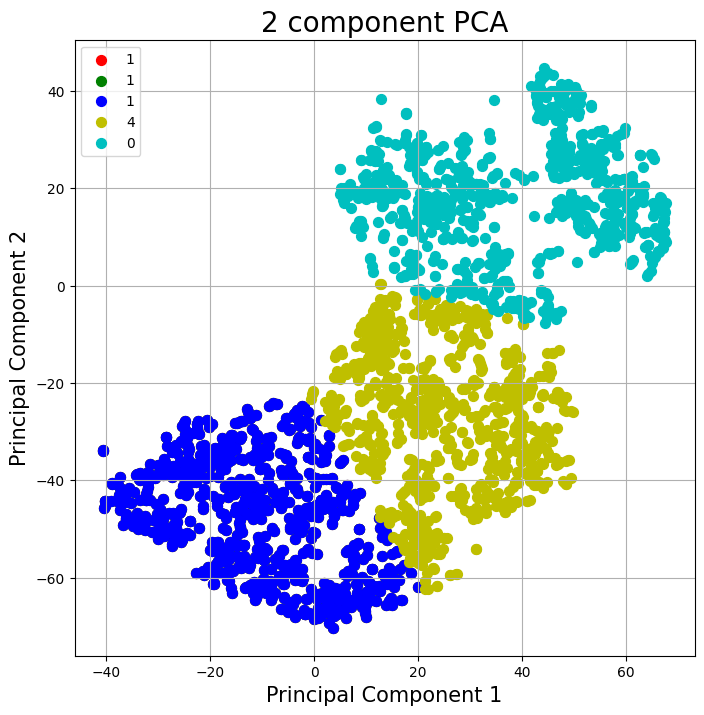

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kmeans.labels_
colors = ['r', 'g', 'b','y','c']
for target, color in zip(targets,colors):
    indicesToKeep = finaldf['Target'] == target
    ax.scatter(finaldf.loc[indicesToKeep, 'PC1']
               , finaldf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [11]:
distance_matrix = gower.gower_matrix(principalDf)

In [12]:
model_single = AgglomerativeClustering(n_clusters=5, linkage='complete', affinity='precomputed')
clusters_single = model_single.fit_predict(distance_matrix)

labels = pd.DataFrame(data = clusters_single, columns = ['labels'])

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Axes: ylabel='count'>

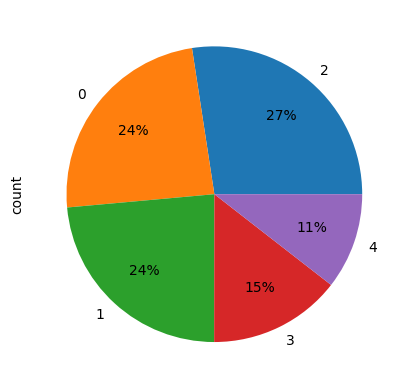

In [13]:
labels['labels'].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

In [14]:
total = pd.concat([labels,df], axis = 1)
total.to_csv("C:\\Users\\riffere\\Desktop\\total.csv")

In [18]:
four = total[total['labels'] == 4][['age', 'gender', 'household_income', 'how_closely_do_you_follow_the_florida_panthers',
        'how_far_in_advance_do_you_normally_purchase_tickets', 'when_do_you_enjoy_going_to_hockey_games',
        'theme_night', 'fans_who_care','exciting_game', 'luxury_seating', 'giveaways', 'ticket_type']]

In [26]:
four['ticket_type'].value_counts()

ticket_type
Single Game        348
Season Tickets      53
Groups              42
Nightly Suites      28
Flex/Mini Plans     20
Name: count, dtype: int64